# **TEXT PREPROCESSING FUNCTION**

In [13]:
import pandas as pd
import re #regular expressions library for text manipulation
import string
import numpy as np
import unicodedata
import ast

from prettytable import PrettyTable

import csv
import os
import random

from glob import glob

#NLP libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
from spacy.lang.en import English
import spacymoji
import emoji
import contractions

import itertools
from autocorrect import Speller

#for wordclouds
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

import matplotlib.pyplot as plt

In [14]:
#additional nlp models
#!python -m spacy download en_core_web_md

In [15]:
def clean_comments (filepath):
    #import data
    df = pd.read_csv(filepath, low_memory = False)
    
    #remove deleted comments if any
    df = df[df.Body != '[deleted]']
    df = df[df.Body != '[removed]']
    df = df.dropna(subset=['Body'])
    
    #remove comments with missing id
    drop_index = df[df.isSubmitter.isnull()].index
    df.drop(drop_index, inplace = True)
    
    #remove duplicates if any
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #correct data types and column label
    df['Date_Created'] = pd.to_datetime(df['Date_Created'])
    df['year'] = df['Date_Created'].dt.year
    df['Score'] = df['Score'].astype('int') 
    df.rename(columns = {'Author_ID': "Author"}, inplace = True) 
    
    #rename 'Body' column to text
    df.rename(columns = {'Body': 'long_text',
                        'Date_Created': 'date_created'}, inplace = True)
    
    #remove unnecessary columns
    df.drop(columns = ['Unnamed: 0', 'Author', 'Score',
       'Parent_ID', 'Submission_ID', 'Subreddit', 'isParent', 'isSubmitter'], inplace = True)
    
    #remove any extra whitespace in column labels
    df.columns = df.columns.str.strip()
    
    #include column to denote row is comment entry
    df['text_type'] = 'comment'
    
    #rearrange column order
    df = df[['text_type','ID','date_created', 'year', 'long_text']]
    
    
        
    return df



In [16]:
def clean_submissions(filepath):
    df = pd.read_csv(filepath, low_memory = False)
    
    #drop duplicate posts
    df = df.drop_duplicates(subset =['ID'], ignore_index = True)
    df.reset_index (drop = True, inplace = True)
    
    #create column for post title + post text
    df['long_text'] = df['Title']+ " " +df['Post Text'].fillna('')
    
    #adjust data types
    df['Date Created'] = pd.to_datetime(df['Date Created'])
    df['year'] = df['year'].astype('int')
    
    #rename columns
    df.rename(columns = {'Date Created': 'date_created'}, inplace = True)
    
    #remove unwanted columns
    df = df.drop(columns = ['Unnamed: 0', 'Title','Post Text', 'Score',
       'Total Comments', 'Post URL', 'SubReddit','Unnamed: 0.1'])
    
    #include column to denote row is comment entry
    df['text_type'] = 'submission'
    
    #reorder columns - 'ID', 'Post Text'
    df  = df[['text_type','ID', 'date_created','year', 'long_text']]
    
    return df
    

In [17]:
#access dataset files
folder_path = os.path.join("..", "Data")
file_type = "*.csv"

#list of dataset file paths
document_path = glob(os.path.join(folder_path, file_type))

document_path

['../Data/corpus_v5.csv',
 '../Data/corpus_v4.csv',
 '../Data/filtered_corpus.csv',
 '../Data/corpus_v3.csv',
 '../Data/corpus_v2.csv',
 '../Data/full_posts.csv',
 '../Data/bert_train_data.csv',
 '../Data/training_data.csv',
 '../Data/vocabulary.csv',
 '../Data/emoji_subset.csv',
 '../Data/bert_train_data2.csv',
 '../Data/sampled_subset.csv',
 '../Data/training_corpus.csv',
 '../Data/comments.csv',
 '../Data/full_data.csv',
 '../Data/corpus.csv']

In [18]:
comments_filepath = '../Data/comments.csv'
submissions_filepath = '../Data/full_posts.csv'


data = pd.concat([clean_comments(comments_filepath), clean_submissions(submissions_filepath)], ignore_index = True)

data

,text_type,ID,date_created,year,long_text
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*"
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi..."
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅
...,...,...,...,...,...
128878,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ..."
128879,submission,14f4uyi,2023-06-21 15:15:27,2023,Found the r/dubai redditors who kept telling m...
128880,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...
128881,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...


In [19]:
year_group = data.groupby(by='year')
for year, group in year_group:
    print (year,len(group))

2012 11
2013 60
2014 143
2015 203
2016 786
2017 1127
2018 1676
2019 4217
2020 29760
2021 28034
2022 36342
2023 26524


## **TEXT PREPROCESSING**

### **Convert all Text to Lowercase**

In [20]:
data['clean_text'] = data['long_text'].apply(lambda text: text.lower())

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
46999,comment,ilc78fu,2022-08-22 20:21:50,2022,"It's not racist or anything, it's just to prev...","it's not racist or anything, it's just to prev..."
22459,comment,g0259kl,2020-08-02 09:16:18,2020,That almost sounds... believeable,that almost sounds... believeable
48347,comment,ghz9htz,2021-01-03 22:37:17,2021,"Fair enough if that’s the case, still looks we...","fair enough if that’s the case, still looks we..."
819,comment,em6w993,2019-05-01 05:50:29,2019,Same here. That doesnt make you any special bt...,same here. that doesnt make you any special bt...
27256,comment,frjrfkg,2020-05-23 17:41:15,2020,Covid don't hertz me\n\ndon't hertz me\n\nno more,covid don't hertz me\n\ndon't hertz me\n\nno more


## **Expand Word Contractions**

In [21]:
data['clean_text'] = data['clean_text'].apply(lambda text: contractions.fix(text)) 

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
70455,comment,g601w0d,2020-09-20 21:21:54,2020,Why did they not turned on the lights?,why did they not turned on the lights?
44846,comment,fwmwakt,2020-07-02 02:47:13,2020,That's a myth and it's all in their head. Mask...,that is a myth and it is all in their head. ma...
71113,comment,fxlmvg6,2020-07-11 07:24:42,2020,AL-Abwab=\nThe-Doors\n\nTughlaq=\nAre Closing,al-abwab=\nthe-doors\n\ntughlaq=\nare closing
89175,comment,iqsfxd0,2022-10-02 23:29:15,2022,Language is most important thing Arabic speake...,language is most important thing arabic speake...
19654,comment,ir4raac,2022-10-05 14:08:42,2022,Maybe your boss's star sign matches her person...,maybe your boss's star sign matches her person...


## **Remove URLs**

In [22]:
#pd.reset_option('display.max_colwidth')

In [23]:
#index of rows with urls
html_index = data[data['long_text'].str.contains("https")].index
data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music https://youtu....
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,https://www.instagram.com/p/ckhzbwph0c4/?igshi...
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\nhttps://maps.app.go...
...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


In [24]:
#regex pattern for urls
url_pattern = r'https?://\S+'
#replace url with empty string
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(url_pattern, ' ', text, flags=re.MULTILINE))

data.loc[html_index]

,text_type,ID,date_created,year,long_text,clean_text
17,comment,gtgyqzz,2021-04-05 20:49:12,2021,Meditation And Relaxation Music https://youtu....,meditation and relaxation music
83,comment,gpqwzwc,2021-03-05 10:34:53,2021,I am curious about this Apollo Fintech GSX coi...,i am curious about this apollo fintech gsx coi...
93,comment,gpqwrek,2021-03-05 10:31:45,2021,https://www.instagram.com/p/CKhzbwpH0c4/?igshi...,\n\nhere is a video explaining the same.
171,comment,gq3tah4,2021-03-07 19:49:41,2021,"With all due respect, do you expect a law enfo...","with all due respect, do you expect a law enfo..."
290,comment,jb5kpz4,2023-03-06 20:35:11,2023,Here: Dubai Festival City\nhttps://maps.app.go...,here: dubai festival city\n \n\nthen follow th...
...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help‼️uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa: villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...","daily random discussion thread hello,\n\nthis ..."
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency - confus...


## **Remove Accents from Characters**

In [25]:
data['clean_text'] = data['clean_text'].apply(
                                            lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
102156,comment,igeszoz,2022-07-16 20:28:37,2022,play elden ring,play elden ring
661,comment,ifxyj6j,2022-07-13 06:44:02,2022,silence!!!!!!,silence!!!!!!
83763,comment,j7yjwbd,2023-02-10 13:01:38,2023,Not pointless. Nitrogen doesn’t heat up like air,not pointless. nitrogen does not heat up like air
97853,comment,jkaawcg,2023-05-16 01:19:23,2023,That’s BS dude lol,that is bs dude lol
31808,comment,hc5ql0h,2021-09-09 12:13:49,2021,If you're looking for more than the company's ...,if you are looking for more than the company's...


## **Remove Punctuations**

In [26]:
#index of some rows with punctuations
checker_list = ['ifquow','gzl2ec','147gsfl','vtelex',
 '12pqx6m','fuxrd2','2ui6wu','l4gz0u','14f4uyi','14f8d30']

rows_to_check = data[data['ID'].isin(checker_list)].index.tolist()

rows_to_check.extend([32003, 116022,18460,5786,30109])

rows_to_check.extend(html_index)

print(rows_to_check[:5])

[124628, 125097, 126727, 126869, 127216]


In [27]:
#regex pattern for punctuations
punctuation_pattern = r'[^\w\s]'

#remove punctuations using `re.sub() method
data['clean_text'] = data['clean_text'].apply(lambda text: re.sub(r'[^\w\s]', ' ', text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello \n\nthis ...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove New Line & Tab**

In [28]:
#remove `\n` from text
data['clean_text'] = data['clean_text'].str.replace('\n', ' ')
#remove `\t` from text
data['clean_text'] = data['clean_text'].str.replace('\t', ' ')

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guys we made it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hell...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who are asking for money g...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone i am currently looking for jobs t...
...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas are at high risk of fire during th...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this is...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with applying for residency confus...


## **Remove Digits**

In [29]:
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join (word for word in text.split() if word.isalpha()))

data.sample(n=5)

,text_type,ID,date_created,year,long_text,clean_text
19533,comment,j01d8fv,2022-12-13 15:06:06,2022,Doing God’s work! 🙏🏻,doing gods work
60416,comment,i9ui5n3,2022-05-24 23:56:06,2022,Yeah that's back when the money was flowing...,yeah that is back when the money was flowing
128833,submission,14d64wu,2023-06-19 10:03:02,2023,Entry Permit rejected - Reason: IQCS Auto Reje...,entry permit rejected reason iqcs auto rejecti...
66035,comment,jfnxvyl,2023-04-10 09:51:11,2023,or non-vegetarian security cameras :D,or non vegetarian security cameras d
57274,comment,g4sxjs6,2020-09-11 11:25:51,2020,"Tried these the other day, brilliant",tried these the other day brilliant


## **LEMMATIZATION**

In [30]:
nlp = spacy.load('en_core_web_md')

In [31]:
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(' '.join(text))])
#data['clean_text'] = data['clean_text'].apply(lambda text: [token.lemma_ for token in nlp(text)])
data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join(token.lemma_ for token in nlp(text)))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,guy we make it yay
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration to canada australia nz hello d...
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,how to reach people who be ask for money groce...
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,how do you plan to spend your eid holiday any ...
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",hi everyone I be currently look for job tempor...
...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,help uni qualification equivalency letter for ...
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas be at high risk of fire during the ...
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",daily random discussion thread hello this be t...
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,need help with apply for residency confuse abo...


## **Remove Stop Words - SpaCy**

In [32]:
nlp = spacy.load('en_core_web_md')

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word.text for word in nlp(text) if not word.is_stop]))

data.sample(n=10)

,text_type,ID,date_created,year,long_text,clean_text
51249,comment,j6xomfb,2023-02-02 21:03:17,2023,My wife has been offered a boob job from her p...,wife offer boob job pimp bonus
96893,comment,dbdkbyb,2016-12-19 14:32:11,2016,Weren't there supposed to be high-tech cameras...,suppose high tech camera instal deter tailgate
41839,comment,g2qcf4j,2020-08-25 00:56:55,2020,And who are these targeted? I'm assuming high ...,target assume high profile political figure cr...
47512,comment,fmbhk6v,2020-04-03 19:08:16,2020,Where in this may be true for other circustman...,true circustmance come situation dubai govt po...
11427,comment,i6erhhn,2022-04-27 19:13:53,2022,It definitely is!,definitely
297,comment,j0141ps,2022-12-13 12:56:56,2022,Dr. Paul Nassif or Dr. Raj Kanodia for my rhin...,dr paul nassif dr raj kanodia rhinoplasty trus...
74958,comment,irfc1o3,2022-10-07 21:21:24,2022,It happened with me too. I went to Vox in merc...,happen vox mercato mall dubai movie smile watc...
29538,comment,gbnuors,2020-11-09 02:55:53,2020,I’m not happy with the inheritance bit as it m...,happy inheritance bit mean family member creat...
15349,comment,j2thbc9,2023-01-04 01:03:23,2023,"Dude, my friends kid dropped 500 AED at YAS Ma...",dude friend kid drop ae yas mall realize hour ...
6298,comment,fqvcmrg,2020-05-17 04:14:06,2020,"Same here haha!\n\nOh well, we’ve got much big...",haha oh big problem life


In [33]:
#check top words after removal of common stop words

#list of all words in the dataframe
#all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
#fdist = FreqDist(all_words)

#common_words_dict = {word: freq for word, freq in sorted(fdist.items(), key = lambda item: item[1], reverse = True) if freq >= 3000} #fdist.most_common(10)

#table of common words
#common_words_table = PrettyTable(['word', 'count'])
#for word, count in common_words.items():
#    common_words_table.add_row([word, count])

#print (common_words_table)

In [34]:
#save custom stop words list to .txt file

#with open('custom_stop_words.txt', 'w') as file:
#    for word in custom_sw:
#        file.write(f'{word}\n')
#    print ('file saved')

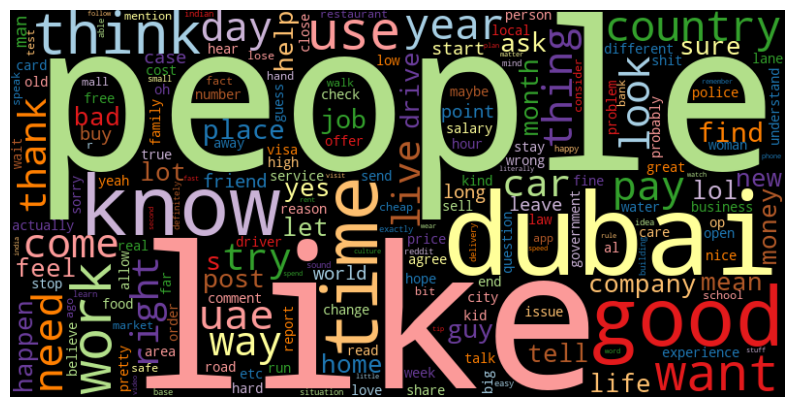

In [35]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [36]:
#load custom_stop_words list
with open('custom_stop_words.txt', 'r') as file:
    custom_sw = [line.strip() for line in file]
print (f'There are {len(custom_sw)} in the custom stop words list')
print ('\n')
print (random.sample(custom_sw, 5))

There are 32792 in the custom stop words list


['socmed', 'kkk', 'palestinine', 'bloc', 'dovey']


In [37]:
#remove custom words

data['clean_text'] = data['clean_text'].apply(lambda text: ' '.join([word for word in text.split() if word not in custom_sw]))

data.sample(n=5)                                    

,text_type,ID,date_created,year,long_text,clean_text
81467,comment,ii0vusr,2022-07-28 22:38:25,2022,How devastating! Alhamdullah everyone is safe ...,devastating safe authority recover disaster
109172,comment,fvd3lj3,2020-06-19 22:39:08,2020,It's an ad. OP is just gaining him more expose...,gain expose closed
111351,comment,hadvro9,2021-08-26 08:18:17,2021,"Am 30 tomorrow, still didn’t find the one to c...",wife age
43312,comment,j99nlco,2023-02-20 12:45:07,2023,When I don’t shave,shave
23494,comment,hz0r7dc,2022-03-02 10:54:00,2022,Agreed.. Saudi was the biggest surprise.. Hand...,saudi surprise aunt remark saudi arabia saudi ...


In [38]:
#check top words after removal of common stop words

#list of all words in the dataframe
all_words = [word for text in data['clean_text'] for word in text.split()]

#frequency of word occurrence
fdist = FreqDist(all_words)

#common_words = fdist.most_common(10)

#table of common words
common_words_table = PrettyTable(['word', 'count'])
for word, count in fdist.most_common(10):
    common_words_table.add_row([word, count])

print (common_words_table)

+---------+-------+
|   word  | count |
+---------+-------+
|  drive  |  2951 |
|   buy   |  2721 |
|   fine  |  2272 |
|   food  |  2269 |
|  price  |  2232 |
|   stop  |  2133 |
|  family |  2130 |
|  police |  2088 |
|   lane  |  2075 |
| service |  1891 |
+---------+-------+


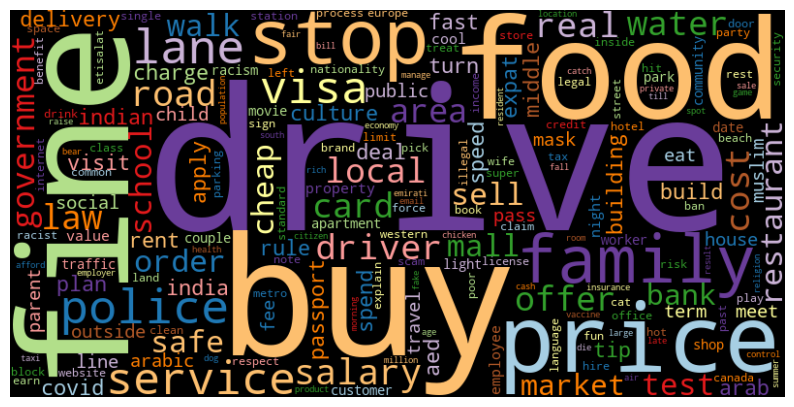

In [39]:
#wordcloud of most frequent words


# Generate the word cloud
wordcloud = WordCloud(
                width=800, 
                height=400,  
                background_color="black", 
                colormap="Paired").generate_from_frequencies(#dictionary of word and their frequency of occurrence
                                                        FreqDist(
                                                            [word for text in data['clean_text'] for word in text.split()])
                        )

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## **Remove Extra Whitespaces**

In [41]:
data['clean_text'] = data['clean_text'].str.strip().str.replace('\s+', ' ', regex = True)

sample_rows = [5786,18460, 103391]

#redo word_count
#data['word_count'] = data['clean_text'].apply (lambda text: len(text.split()))

data.loc[sample_rows]#.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text
5786,comment,j8mroan,2023-02-15 17:37:07,2023,Confirmed; it’s true. Just need to have the ac...,plate
18460,comment,hzk2ggz,2022-03-06 12:55:36,2022,Encourage pointless posts on Reddit,encourage pointless
103391,comment,j7zocx9,2023-02-10 19:39:10,2023,I really want this to happen. Especially repla...,replace shitty spelling lovindubai


## **Word Tokenization - NLTK**

In [42]:
data['tokens'] = data['clean_text'].apply(lambda text: word_tokenize(text))

data.iloc[rows_to_check]

,text_type,ID,date_created,year,long_text,clean_text,tokens
124628,submission,ifquow,2020-08-24 19:13:26,2020,GUYS WE MADE IT!!! YAY,yay,[yay]
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia inquiry immig...,"[psa, immigration, canada, australia, inquiry,..."
126727,submission,147gsfl,2023-06-12 10:22:19,2023,How to reach people who are asking for money/g...,grocery normally society requirement donation ...,"[grocery, normally, society, requirement, dona..."
126869,submission,12pqx6m,2023-04-17 22:00:27,2023,How do you plan to spend your Eid holiday? Any...,plan spend eid holiday fun activity trip line ...,"[plan, spend, eid, holiday, fun, activity, tri..."
127216,submission,vtelex,2022-07-07 13:32:10,2022,"Hi everyone, I'm currently looking for jobs te...",temporary permanent visa drive license thankful,"[temporary, permanent, visa, drive, license, t..."
...,...,...,...,...,...,...,...
128777,submission,14djkvs,2023-06-19 20:39:46,2023,Help‼️Uni qualification equivalency letter for...,uni qualification letter master application co...,"[uni, qualification, letter, master, applicati..."
128835,submission,14d2uk9,2023-06-19 07:06:28,2023,PSA: Villas are at high risk of fire during th...,psa villas risk fire summer community fire vil...,"[psa, villas, risk, fire, summer, community, f..."
128837,submission,14d0c29,2023-06-19 05:00:13,2023,"Daily Random Discussion Thread Hello,\n\nThis ...",active monthly june monthly classified june mo...,"[active, monthly, june, monthly, classified, j..."
128868,submission,14cieby,2023-06-18 15:43:08,2023,Need help with applying for residency - confus...,apply residency confuse order land virtual ent...,"[apply, residency, confuse, order, land, virtu..."


## **Insert Word Count**

In [43]:
data['word_count'] = data['tokens'].apply (lambda tokens_list: len(tokens_list))

data.sort_values(by='word_count', ascending = False)

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
125097,submission,gzl2ec,2020-06-09 15:11:27,2020,"PSA: Immigration to Canada, Australia, NZ Hell...",psa immigration canada australia inquiry immig...,"[psa, immigration, canada, australia, inquiry,...",755
125384,submission,jh5hjq,2020-10-24 12:29:05,2020,List of discounts and working promo codes in D...,discount promo code discount promo code tip di...,"[discount, promo, code, discount, promo, code,...",634
5756,comment,ji1smg1,2023-04-28 17:10:21,2023,"FULLTEXT\nApr 27, 2023\n\nStand in the middle ...",apr middle meena bazaar mile arabian sea mumba...,"[apr, middle, meena, bazaar, mile, arabian, se...",414
18342,comment,jj2t0ih,2023-05-06 15:40:03,2023,"FULL TEXT:\n\nBy Archana Narayanan, Abeer Abu ...",text omar bloomberg gamble industry bet united...,"[text, omar, bloomberg, gamble, industry, bet,...",369
29821,comment,hb5qzzy,2021-09-01 10:58:17,2021,How to get a visit visa to the UAE?\n\ngulfnew...,visit visa gulfnews com purpose image credit s...,"[visit, visa, gulfnews, com, purpose, image, c...",369
...,...,...,...,...,...,...,...,...
72064,comment,hw7pbv5,2022-02-09 15:47:55,2022,"That doesn't 'APPen very often, as stated by OP",,[],0
72065,comment,hw7vwax,2022-02-09 16:53:58,2022,Free,,[],0
108480,comment,hbx4y5h,2021-09-07 15:42:40,2021,They are human too just like you.,,[],0
108479,comment,hbx4btl,2021-09-07 15:35:42,2021,Oh please.,,[],0


## **Get Subset Sample**

In [45]:
#load list of sample_subset indices

#sampling done previously by randomly selecting entries from each year

with open('sample_subset_index.txt', 'r') as file:
    subset_index = [line.strip() for line in file]

subset_index[:5]

['hbbcq6z', 'hjjhl9r', 'h7ntxws', 'h02sz1n', 'hnuysoa']

In [49]:
#subset sample
subset_data = data[data['ID'].isin(subset_index)]

subset_data

#save subset data
filename = '../Data/subset_sample_no_label.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    subset_data.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

file saved


## **Remove Subset for manual labelling**

In [51]:
#remove randomly sampled subset


subset_index = subset_data.index.to_list()

#remove sample subset from corpus

training_data = data.drop(subset_index, axis = 0)
training_data.sort_values(by='word_count', ascending = False)

training_data

,text_type,ID,date_created,year,long_text,clean_text,tokens,word_count
0,comment,gtfo2hl,2021-04-05 13:00:32,2021,"*Cuntry roads, take me hoem*",road,[road],1
1,comment,gtfqkbv,2021-04-05 13:41:40,2021,"That’s been there for several years, sent a pi...",,[],0
2,comment,gtfou07,2021-04-05 13:13:23,2021,I am single and I have not traveled to any cun...,single travel past,"[single, travel, past]",3
3,comment,gtfrgpe,2021-04-05 13:56:09,2021,What happens when you shop at dragon mart...,shop dragon mart,"[shop, dragon, mart]",3
4,comment,gtg5mwv,2021-04-05 16:51:54,2021,I am cunting on them to do so 😅,,[],0
...,...,...,...,...,...,...,...,...
128878,submission,14f46ji,2023-06-21 14:40:54,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",beauty saloon fella wife real saloon beauty sa...,"[beauty, saloon, fella, wife, real, saloon, be...",17
128879,submission,14f4uyi,2023-06-21 15:15:27,2023,Found the r/dubai redditors who kept telling m...,navigate roundabout,"[navigate, roundabout]",2
128880,submission,14f4ri3,2023-06-21 15:10:25,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card april ...,"[scam, healthy, line, sister, cbd, debit, card...",35
128881,submission,14f4k3r,2023-06-21 15:00:34,2023,Thoughts on Expo City properties? Anyone else ...,expo property expo sale pleasant price locate ...,"[expo, property, expo, sale, pleasant, price, ...",9


## **Remove Short Text Entries**

In [52]:
#select only rows with more than 1 word
corpus = training_data[training_data['word_count'] > 2]

corpus.shape

(65987, 8)

## **SAVE DATA**

In [53]:
#save corpus 
filename = '../Data/training_data.csv'

def export_csv():
    '''
    export pre-processed data to CSV
    '''
    corpus.to_csv(filename, index_label = 'index', quoting = csv.QUOTE_ALL, header = True)

export_csv()

print ('file saved')

file saved


## **Translate Emoticons**

In [ ]:
"""def find_emoji(text):
    try:
        emoticon_details = next(emoji.analyze(text, join_emoji=True))
        emoticon = emoticon_details.chars
        #translated_emoji = emoji.demojize(emoticon.chars)
    except StopIteration:
        emoticon = ''  # Handle the case when no emoji is found
    return  emoticon

data['emoticons'] = data['long_text'].apply (lambda text: find_emoji(text) )
data['translated_emojis'] = data['emoticons'].apply(lambda text: emoji.demojize(text))

emoji_index = [3709,33734,129114,100878]

data.loc[emoji_index]"""